In [32]:
import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [33]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-Behcet-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-CEA-CEF-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Paired_rerun-TRB_HUMAN-after-reassignment.csv']

In [34]:
pt_file="20180604_Run029_pt-table.csv"
plotfile="run29-" + celltype + '.pdf'

## Import clonesdata

In [35]:
clones = pd.read_csv(myfiles[0], sep="\t")
for clones_file in myfiles[1:]:
    clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [36]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,B001-T_S17,ACGTACGT,CSVLVAGGLGEQFFG,4977,1448,TRBV29-1,"TRBJ2-1,TRBJ2-7,TRBJ2-5",9914,1.991963,6.831471,4.429083
1,B001-T_S17,ACGTACGT,CSVGKGPTNYGYTFG,1334,384,TRBV29-1,"TRBJ1-2,TRBJ2-1,TRBJ2-7",2653,1.988756,1.831059,1.174563
2,B001-T_S17,ACGTACGT,CSVPTRDTEAFFG,821,220,TRBV29-1,TRBJ1-1,1632,1.987820,1.126911,0.672927
3,B001-T_S17,ACGTACGT,CSVARRVYNEQFFG,612,203,TRBV29-1,TRBJ2-1,1215,1.985294,0.840036,0.620928
4,B001-T_S17,ACGTACGT,CSVGGGNSPLHFG,534,146,TRBV29-1,"TRBJ1-6,TRBJ2-7",1592,2.981273,0.732973,0.446579


## Import patient table

In [37]:
pt = pd.read_csv(pt_file, sep="\t")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})

In [38]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [39]:
pt.head()

,Sample,Patient
0,BMC110-1-BuH_S1,BMC110
1,BMC110-2-BuH_S2,BMC110
2,BMC111-1-BuH_S3,BMC111
3,BMC111-2-BuH_S4,BMC111
4,BMC116-1-BuH_S5,BMC116


## Merge clones with pt

In [40]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df = df.set_index(['Patient', 'Sample'])
df.head()

MID          cdr3pep  freq  uniq_umis     V_sub  \
Patient Sample                                                             
B001    B001-T_S17  ACGTACGT  CSVLVAGGLGEQFFG  4977       1448  TRBV29-1   
        B001-T_S17  ACGTACGT  CSVGKGPTNYGYTFG  1334        384  TRBV29-1   
        B001-T_S17  ACGTACGT    CSVPTRDTEAFFG   821        220  TRBV29-1   
        B001-T_S17  ACGTACGT   CSVARRVYNEQFFG   612        203  TRBV29-1   
        B001-T_S17  ACGTACGT    CSVGGGNSPLHFG   534        146  TRBV29-1   

                                      J_sub  sum_sites  avg_sites  read_perc  \
Patient Sample                                                                 
B001    B001-T_S17  TRBJ2-1,TRBJ2-7,TRBJ2-5       9914   1.991963   6.831471   
        B001-T_S17  TRBJ1-2,TRBJ2-1,TRBJ2-7       2653   1.988756   1.831059   
        B001-T_S17                  TRBJ1-1       1632   1.987820   1.126911   
        B001-T_S17                  TRBJ2-1       1215   1.985294   0.840036   
        B001-T_S17          TRBJ1-6,TRBJ2-7       1592   2.981273   0.732973   

                    umi_perc  
Patient Sample                
B001    B001-T_S17  4.429083  
        B001-T_S17  1.174563  
        B001-T_S17  0.672927  
        B001-T_S17  0.620928  
        B001-T_S17  0.446579

## Count overlapping clones between samples

In [41]:
# Sort index for better performance
df = df.sort_index()

# Make empty data frame for the distance matrix
colnames = list(set(df.index))
colnames
colnames.sort()
overlap = pd.DataFrame(index=colnames, columns=colnames, dtype=np.float)

In [42]:
# Function to count overlapping elements (cdr3pep): Jaccard index
jaccard = lambda x, y: len(set(x).intersection(set(y))) / len(set(x).union(set(y)))

In [43]:
# Function to count overlapping elements (cdr3pep): Sorensen index
sorensen = lambda x, y: 2 * len(set(x).intersection(set(y))) / (len(set(x)) + len(set(y)))

In [44]:
# Function to count overlapping elements, taking abundance into account: Bray-Curtis (Sorensen generalized)
def bray_curtis(x,y):
    '''
    From: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.1334&rep=rep1&type=pdf
    In: x (dataframe), y (dataframe)
    Out: similarity (number)
    '''
    merged = pd.merge(x, y, how='outer', on = 'cdr3pep')
    merged = merged.fillna(0)   # Replace NaN with 0
    merged['minimum'] = [i for i in map(min, merged['freq_x'], merged['freq_y'])]
    similarity = 2 * sum(merged['minimum']) / (sum(merged['freq_x']) + sum(merged['freq_y']))
    return(similarity)

In [45]:
# Function to count overlapping elements, taking abundance into account: Bray-Curtis
def jaccard_generalized(x,y):
    '''
    From: https://en.wikipedia.org/wiki/Jaccard_index
    In: x (dataframe), y (dataframe)
    Out: similarity (number)
    '''
    #x = df.loc[('M5', 'Eomes-01_S9')][['cdr3pep', 'read_perc']]
    #y = df.loc[('M5', 'Eomes-02_S10')][['cdr3pep', 'read_perc']]
    merged = pd.merge(x, y, how='outer', on = 'cdr3pep')
    merged = merged.fillna(0)   # Replace NaN with 0
    merged['minimum'] = [i for i in map(min, merged['freq_x'], merged['freq_y'])]
    merged['maximum'] = [i for i in map(max, merged['freq_x'], merged['freq_y'])]
    similarity = sum(merged['minimum']) / sum(merged['maximum'])
    return(similarity)

In [46]:
# Calculate distance between all samples
for x in overlap.index:
    for y in overlap.index:
        #overlap[x][y] = max(sorensen(df.loc[x]['cdr3pep'], df.loc[y]['cdr3pep']), 0.0000000001)
        overlap[x][y] = max(bray_curtis(df.loc[x][['cdr3pep', 'freq']], df.loc[y][['cdr3pep', 'freq']]), 0.0000000001)

In [47]:
overlap.head()

,"(A25, CEA-E01-Tu_S61)","(A25, CEA-E02-Tu_S62)","(A25, CEA-E03-Tu_S63)","(A25, CEA-E04-Tu_S77)","(A25, CEA-E06-Tu_S78)","(A25, CEA-E07-Tu_S79)","(A25, CEA-E08-Tu_S80)","(A25, CEA-E10-Tu_S81)","(A25, CEA-E11-Tu_S82)","(A25, CEA-E12-Tu_S99)",...,"(P452, CEA-F30-Tu_S197)","(P452, CEA-F31-Tu_S210)","(P452, CEA-F32-Tu_S211)","(P452, CEA-F33-Tu_S212)","(P452, CEA-F34-Tu_S213)","(P452, CEA-F35-Tu_S214)","(P452, CEA-F36-Tu_S215)","(P452, CEA-F37-Tu_S216)","(P452, CEA-F38-Tu_S217)","(P452, CEA-F39-Tu_S232)"
"(A25, CEA-E01-Tu_S61)",1.000000,0.072064,0.100018,0.049010,0.056016,0.038733,0.023346,0.050931,0.052722,0.045776,...,0.002493,0.001772,0.002063,0.002109,0.002266,0.001684,0.002347,0.001819,0.001849,0.001754
"(A25, CEA-E02-Tu_S62)",0.072064,1.000000,0.133206,0.136668,0.137854,0.032156,0.015248,0.081566,0.107038,0.101939,...,0.002936,0.001612,0.001766,0.001856,0.002409,0.001976,0.002667,0.001607,0.001906,0.001289
"(A25, CEA-E03-Tu_S63)",0.100018,0.133206,1.000000,0.104014,0.115730,0.035185,0.019262,0.088359,0.095016,0.086721,...,0.001251,0.001439,0.001366,0.001308,0.001907,0.001243,0.001698,0.001683,0.001414,0.001613
"(A25, CEA-E04-Tu_S77)",0.049010,0.136668,0.104014,1.000000,0.173108,0.021676,0.010422,0.089829,0.107313,0.117408,...,0.003185,0.003698,0.003839,0.003624,0.002442,0.003061,0.003017,0.002937,0.002377,0.002107
"(A25, CEA-E06-Tu_S78)",0.056016,0.137854,0.115730,0.173108,1.000000,0.026418,0.014615,0.099765,0.123040,0.127394,...,0.003803,0.004771,0.004857,0.006159,0.003810,0.004954,0.004660,0.003475,0.003464,0.003312


In [48]:
# Replace NaN and zero's with low number
overlap[overlap.isna()] = 0.0000000001
overlap[overlap == 0] = 0.0000000001

## Create a heatmap

In [49]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [50]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

Wrote run29-TRB_HUMAN.pdf to disk


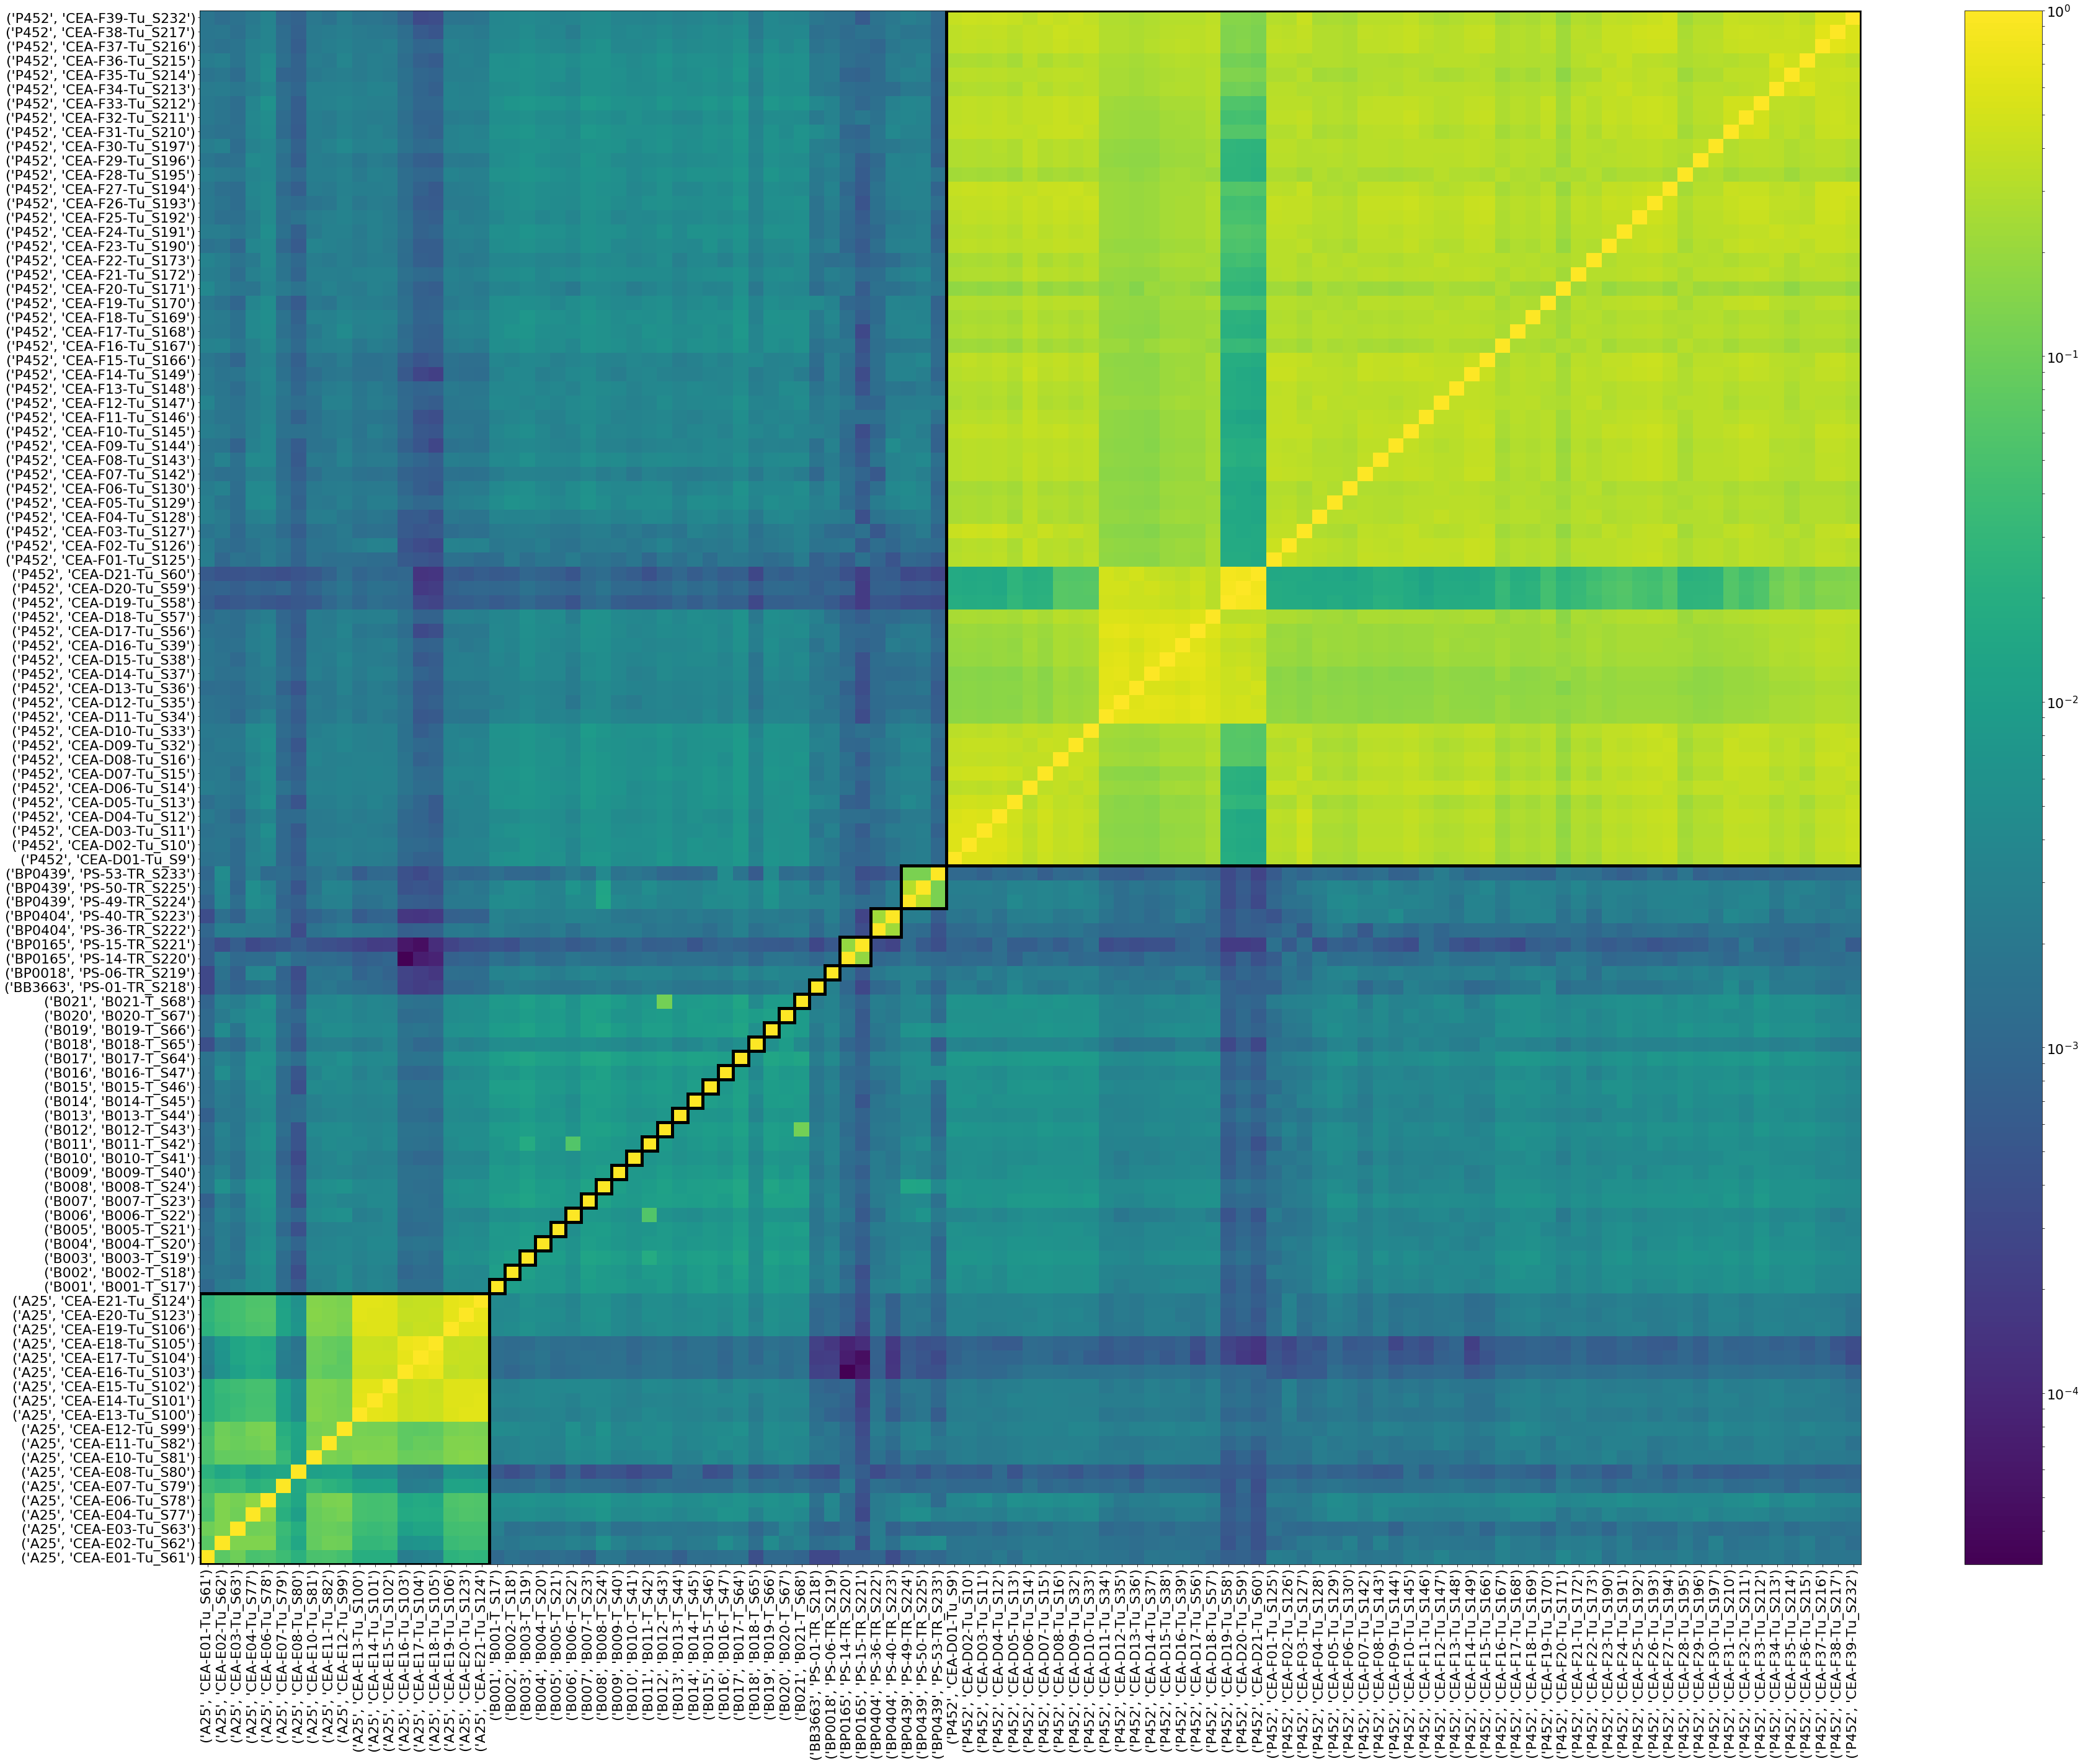

In [51]:
drawHeatmap(overlap)